# 목차

[- 문제정의](#indexone)  
    - 포스트 코로나 시대 상황 인식  


[- 주제선정](#indextwo)  
    - 집단감염 분석하기  
        - 집단감염사례 제거 과정  
        - 집단감염에서의 n차 감염자까지 제거 
    - 서울 유동인구 분석하기
    - 인사이트 도출하기  
        - 재택근무 제도
        - 포스트 코로나 시대, 재택근무 대비 서비스<구독경제>            
        
        
[- 데이터분석](#indexthree)  
    - 가설  
    - delivery 데이터 파헤치기   
         - 예측모델 fbprophet  
    - card데이터 파헤치기   
        - 데이터 전처리  
        - card데이터 분석  
        - 데이터 시각화  
 
 
[- 결론 및 활용방안](#indexfour)  
    - PSS의 개념  
        - PSS란?  
        - PSS의 형태  
    - PSS산업의 성장 동향과 사례  
    - PSS조합하기  
    - 결론  





# **<div id="indexone">01.문제정의</div>**


## - 포스트 코로나 시대 상황 인식
>먼저 저희는 코로나 장기적으로 지속되고 있는 이 시기에 먼저 코로나 확산의 **<span style="color:blue">원인</span>**과**<span style="color:blue"> 해결방안</span>**에 관하여 조사를 진행하였습니다.


 * 코로나 확산의 주범, '집단감염'과 그에 대항 수단

![](https://img7.yna.co.kr/etc/graphic/YH/2020/06/16/GYH2020061600230004400_P4.jpg)

기사 주소 : https://www.yna.co.kr/view/GYH20200616002300044


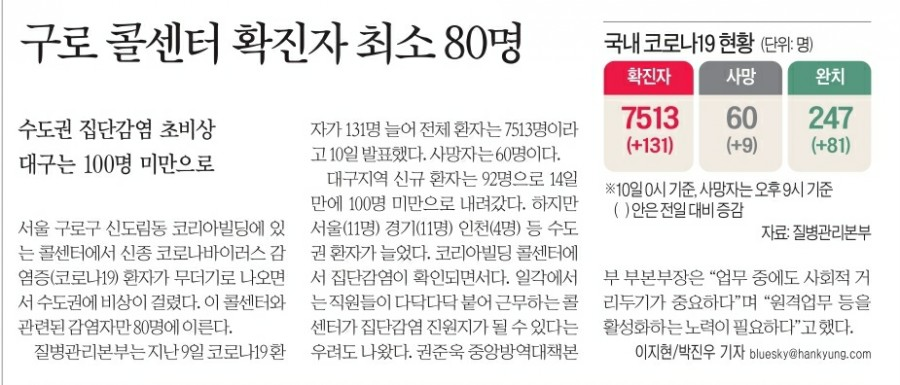

In [1]:
from IPython.display import Image

Image("C:/Users/YH/Desktop/공모전/guro.jpg")

기사 주소 : https://blog.naver.com/ug2dancer1/221847941239


> 지난 1월, 코로나 최초 국내확진자가 발생하고 나서 코로나 확진자가 급증한 계기를 떠올려 보니 대부분 집단감염을 통해 확산되었습니다.

> 수도권을 기준으로 봤을 때에도 산발적인 집단감염이 발생하고 있어, 방역당국의 통제 속도가 이를 따라가지 못하고 있습니다.

> 코로나의 폭발적 확산은 __<span style="color:red">집단감염</span>__에 기인하고 있다고 보고 이에 대한 분석을 하였고, 이런 집단감염에 대한 해결방안으로 __<span style="color:red">인구 밀도를 최대한 낮추는 방향</span>__에 대하여 분석을 진행하였습니다.


# <div id="indextwo">02.주제선정</div>

## 1)  **집단감염 분석하기**



> 우선 저희는 코로나 확진자 데이터에서 집단감염자를 제외시켜보았습니다. 직접적인 감염자뿐만 아니라, 그 감염자들에 의한 n차 감염자까지 모두 제외시킨후 그래프로 나타냈습니다.



In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import plotly.graph_objects as go
import plotly.express as px

import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import style
from plotly.subplots import make_subplots
from dateutil.easter import easter

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
import logging
import plotly.io as pio
import matplotlib
import matplotlib.font_manager as fm

fm.get_fontconfig_fonts()
font_location = 'C:/Windows/Fonts/H2HDRM.TTF' 
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

pio.renderers.default = 'notebook_connected'
warnings.filterwarnings(action='ignore')
logging.getLogger('fbprophet').setLevel(logging.WARNING)

### - 집단감염 사례 제거 과정

In [3]:
pat_all = pd.read_csv("C:/Users/YH/Desktop/공모전/KT_data/COVID_19/PatientInfo.csv")

# 감염case가 contact with patient 인 데이터 추출
pat_from_pat = pat_all.loc[pat_all['infection_case']=="contact with patient"]

# pat_from_pat1 : 감염자
pat_from_pat1 = pat_from_pat[['patient_id']]
pat_from_pat1 = pat_from_pat1.reset_index()
pat_from_pat1 = pat_from_pat1.drop(['index'],axis=1)
pat_from_pat[['infected_by']] = pd.to_numeric(pat_from_pat['infected_by'])

# pat_from_pat2 : 전파자
pat_from_pat2 = pat_from_pat[['infected_by']] #환자
pat_from_pat2 = pat_from_pat2.reset_index()
pat_from_pat2 = pat_from_pat2.drop(['index'],axis=1)

### - 집단감염 사례에서의 n차 감염자까지 제거

In [4]:
def make_list(event_name): #event_name : infection_case 이름
   
    #event_name의 환자 추출
    pat_event = pat_all.loc[pat_all['infection_case']==event_name]
    pat_event_id = pat_event[['patient_id']]
    pat_event_id = pat_event_id.reset_index()
    pat_event_id = pat_event_id.drop(['index'],axis=1)
    
    #event_name의 환자 list화
    from_event_id =[]
    for i in range(len(pat_event_id)):
        from_event_id.append(pat_event_id['patient_id'][i])
    by_id = []
    for i in range(len(pat_from_pat2)):
        by_id.append(pat_from_pat2['infected_by'][i])
        
    #while문 탈출 조건    
    n= 0
    m =0
    
    #event_name의 감염자 및 n차 감염자 추출
    while(True):
        n =len(from_event_id)
        
        #event_name의 감염자 id와 pat_from_pat의 전파자 id가 같으면 list에 저장
        for i in range(len(from_event_id)):
            for j in range(len(by_id)):
                if(by_id[j]==from_event_id[i]):
                    from_event_id.append(pat_from_pat1['patient_id'][j])
                    from_event_id = list(set(from_event_id)) #중복제거
        
        m =len(from_event_id)
        
        #더이상 n차 감염자가 없다면 while문 탈출
        if (n==m):
            break
            
    pat_res= pat_all
    idx_nm1 = []
    
    #전체 환자에서 event_name의 모든 감염자(n차 감염자 포함) 제거
    for i in range(len(from_event_id)):
        idx_nm1.append(pat_all[pat_all['patient_id']==from_event_id[i]].index)

    for j in range(len(idx_nm1)):
        pat_res = pat_res.drop(idx_nm1[j])
        
    #n차 감염자까지 제거 후 데이터와 감염자 id list 출력
    return pat_res, from_event_id

In [5]:
def make_plot(df_name):
    pc = df_name.groupby(['confirmed_date']).size().reset_index(name='count')
    pc['confirmed_date'] = pd.to_datetime(pc['confirmed_date'], format='%Y-%m-%d')
    return pc

def make_csum_plot(df_name):
    pc = df_name.groupby(['confirmed_date']).size().cumsum().reset_index(name='count')
    pc['confirmed_date'] = pd.to_datetime(pc['confirmed_date'], format='%Y-%m-%d')
    return pc

In [6]:
#구로 데이터 비교
pat_guro, k = make_list('Guro-gu Call Center')

pc_all = make_plot(pat_all)
pc_guro = make_plot(pat_guro)
fig1 = px.line(pc_all, x = 'confirmed_date', y = 'count')
fig1.add_scatter(x=pc_guro['confirmed_date'], y = pc_guro['count'], name = 'Guro_call')
fig1.update_layout(
    title={
        'text': "구로콜센터 집단감염 제외 후 코로나 감염자 수 양상",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig1.show()

In [7]:
#신천지 데이터 비교
pat_shin ,m= make_list('Shincheonji Church')

pc_all = make_plot(pat_all)
pc_shin = make_plot(pat_guro)
fig1 = px.line(pc_all, x = 'confirmed_date', y = 'count')
fig1.add_scatter(x=pc_shin['confirmed_date'], y = pc_shin['count'], name = 'Shincheonji Church')
fig1.update_layout(
    title={
        'text': "신천지 교회 집단감염 제외 후 코로나 감염자 수 양상",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig1.show()

In [8]:
#이태원클럽 데이터 비교
pat_itaewon , n= make_list('Itaewon Clubs')

pc_all = make_plot(pat_all)
pc_itaewon = make_plot(pat_itaewon)
fig1 = px.line(pc_all, x = 'confirmed_date', y = 'count')
fig1.add_scatter(x=pc_itaewon['confirmed_date'], y = pc_itaewon['count'], name = 'Itaewon Clubs')
fig1.update_layout(
    title={
        'text': "이태원 클럽 집단감염 제외 후 코로나 감염자 수 양상",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig1.show()

In [9]:
a = [k, n, m]

#pat_res : 세가지 집단감염자 모두 제거한 데이터
pat_res= pat_all
for b in range(len(a)):
    c = a[b]
    idx_nm1 = []
    for i in range(len(c)):
        idx_nm1.append(pat_all[pat_all['patient_id']==c[i]].index)

    for j in range(len(idx_nm1)):
        pat_res = pat_res.drop(idx_nm1[j])
        
pc_all = make_plot(pat_all)
pc_res = make_plot(pat_res)

pc_csum_all = make_csum_plot(pat_all)
pc_csum_res = make_csum_plot(pat_res)

fig1 = px.line(pc_all, x = 'confirmed_date', y = 'count')
fig1.add_scatter(x=pc_res['confirmed_date'], y = pc_res['count'], name = '집단감염 제외')
fig1.update_layout(
    title={
        'text': "세가지 집단감염 제외 후 코로나 감염자 수 양상",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig1.show()

fig2 = px.line(pc_csum_all, x = 'confirmed_date', y = 'count')
fig2.add_scatter(x=pc_csum_res['confirmed_date'], y = pc_csum_res['count'], name = '집단감염 제외')
fig2.update_layout(
    title={
        'text': "세가지 집단감염 제외 후 코로나 감염자 수 양상 (누적)",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig2.show()

> 분석을 통해 집단감염의 파급력에 대해 조금이나마 알게 되었습니다. 

> 슈퍼 전파자 : 다수의 개인에게 질병을 퍼뜨리는 사람  
출처 : 헬스컨슈머(http://www.healthumer.com)

> 집단감염이 일어날 가장 위험한 조건은 많은 사람들과의 접촉입니다. 저희는 많은 사람들과 접촉을 한다는 것을 유동량으로 표현하고 각 연령대별 유동인구 수를 분석해 보았습니다. 그렇다면 어떤 연령대가 가장 많은 유동량을 보이고 있는 __잠재적 슈퍼 전파자__ 일까요? Tableau를 통해 서울 각 구의 연령대별 유동인구를 분석해보았습니다. 

## 02) 서울 유동인구 분석하기

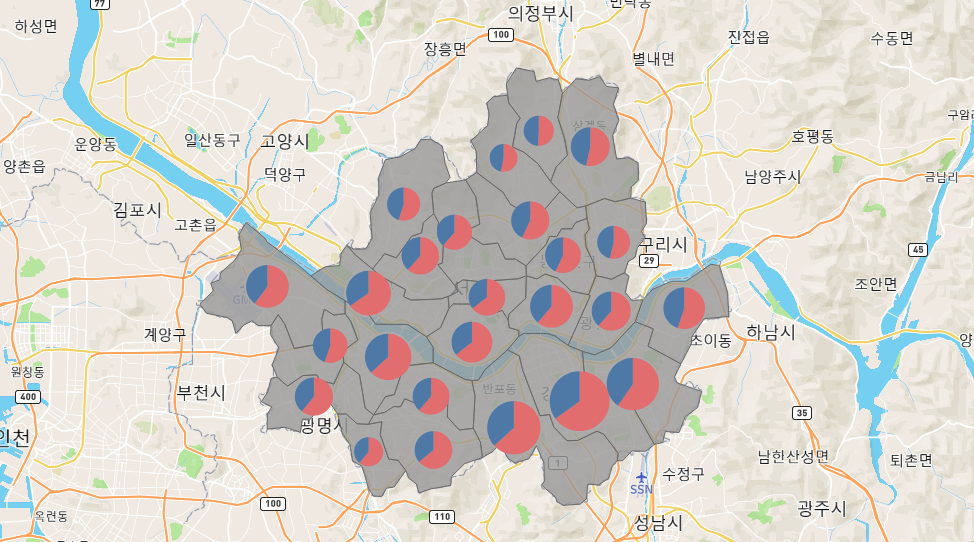

In [10]:
Image("C:/Users/YH/Desktop/공모전/map.png")

> 위의 그림에서 파이차트의 크기는 총 유동량을 의미하고, <span style="color:red">빨간색</span> 부분은 <span style="color:red">20-40대</span>의 유동인구수를 의미합니다.서울 전 지역에서 분석해본 결과 20-40대의 연령층이 유동인구의 과반수 이상을 차지하고 있다는 사실을 알 수 있습니다.



## 3) **인사이트 도출하기**

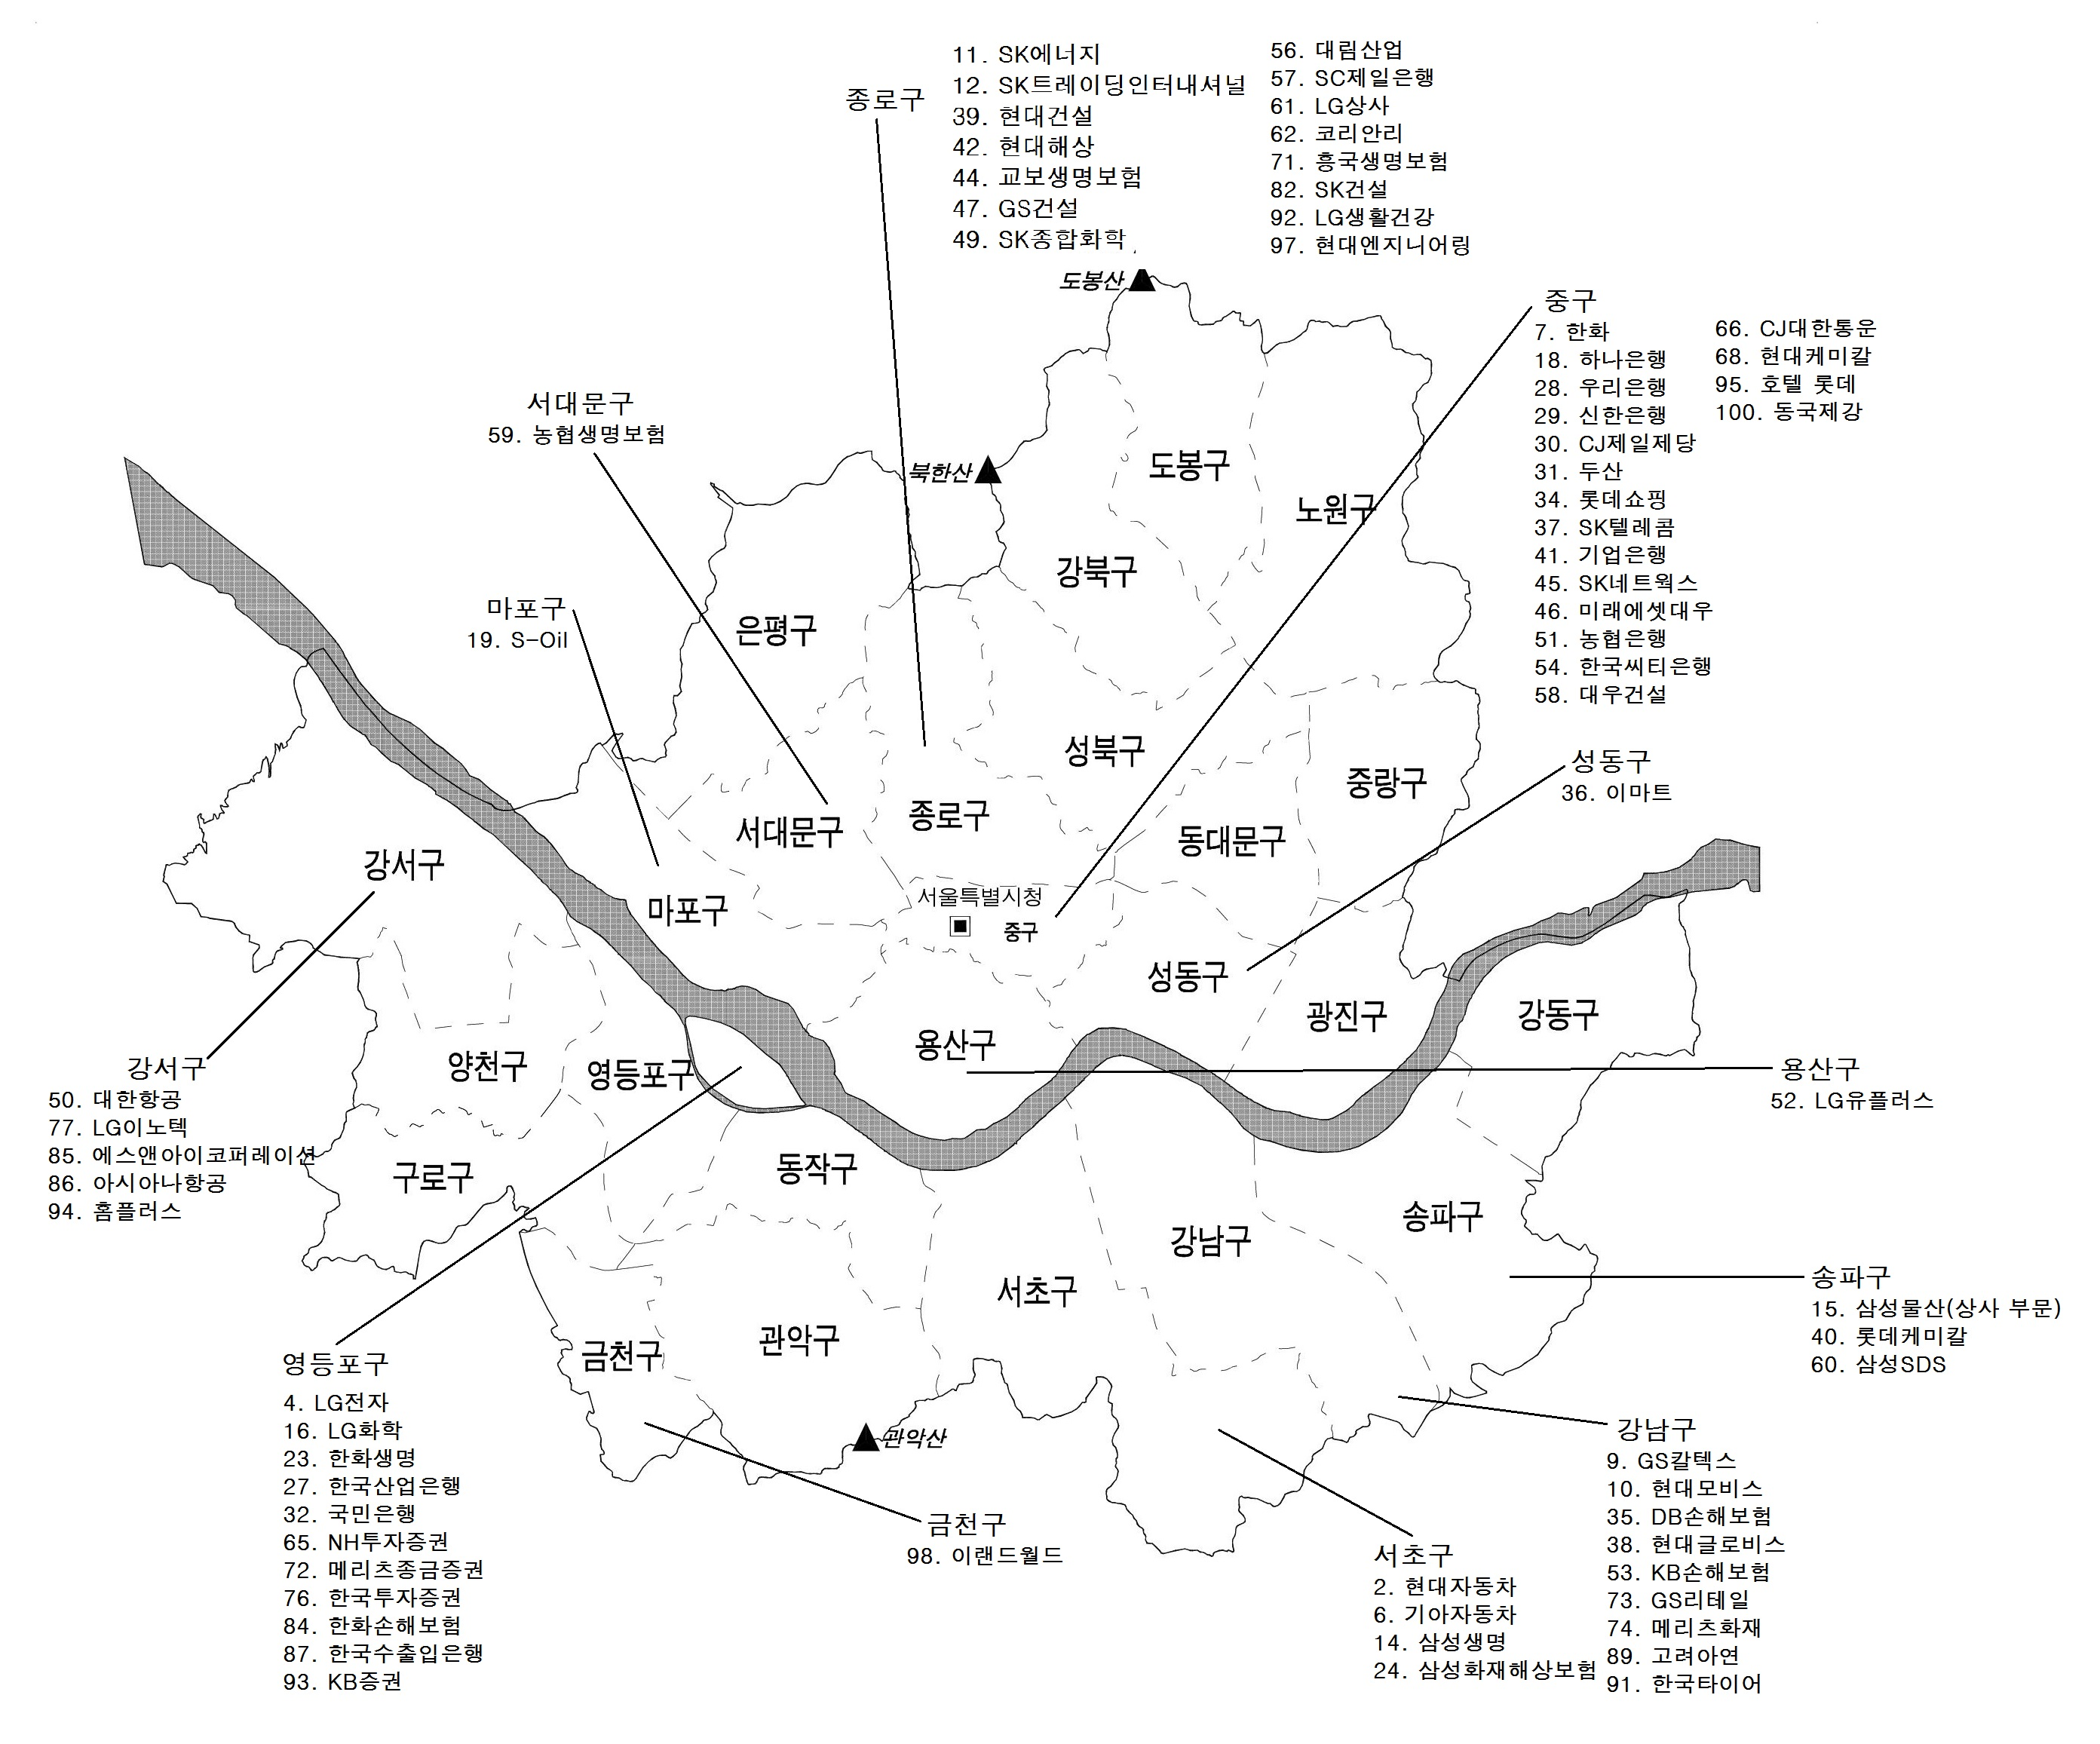

In [11]:
Image("C:/Users/YH/Desktop/공모전/top100.jpg")

> 저희는 국내 100대 기업 위치 자료와 유동인구 데이터를 통해 위의 20-40대의 군집이 <span style="color:red">직장인</span> 군집이라는 사실을 도출 하였습니다.



>  직장에 출·퇴근 하는 시간은 하루 중 인구밀도가 가장 높은 시간입니다. 출·퇴근시에도 대부분 대중교통을 통해 움직이기 때문에 감염되기 쉽고, 동시에 전파자가 되기에도 쉬울 것 입니다. 그렇다면 이렇게 감염에 노출돼있는 __직장인들의 유동량을 줄이는 방법__은 무엇이 있을까요?

> 저희는 그 방법으로 __<span style="color:red">재택근무</span>__의 도입을 생각했습니다.

### - 재택근무 제도


![대체 텍스트](https://imgnews.pstatic.net/image/076/2020/03/11/2020031201000833300051101_20200311112308430.jpg?type=w647)

기사 주소 : https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=076&aid=0003540679



> 실제로 일부 회사에서는 회사에 피해가 가지 않는 선에서, 또는 더 큰 피해를 막기 위해 재택근무를 시행 하고 있습니다.  

> 따라서 저희는 현재 __<U>재택근무 시행으로 인한 소비패턴 변화를 분석</U>__하고, 이에 __<U>유망한 산업을 발굴</U>__하겠다는 목표로 분석을 시작했습니다.


### - 포스트 코로나 시대, 재택근무 대비 서비스 <**<span style="color:red">구독경제</span>**>

- **근거**



> 지금까지의 과정으로 새로운 산업을 도출할 근거를 찾아보았습니다. 

> 주 타겟층은 집단감염을 피해 재택근무를 시행함으로써 생기는 소비패턴변화가 큰 20-40대의 직장인으로 잡았습니다.

> 직장인 군집의 유동성을 줄이며 소비활동을 할 수 있는 방안에 대한 모색을 한 결과 구독 경제라는 인사이트를 도출하였습니다.


- **구독경제(subscription economy)란?**

> 매달 구독료를 내고 필요한 물건이나 서비스를 받아쓰는 활동으로 이미 생산된 제품을 여럿이 함께 **공유해서 사용하는 협력 소비경제**를 뜻합니다.

> 경제학자들은 구독경제의 확산 현상을 ‘효용이론’으로 설명합니다. 제한된 자원과 비용으로 최대한의 만족을 얻기 위한 노력의 결과로 ‘소유’의 시대를 넘어 **'접속'과 '이용'의 시대**가 왔습니다.

- **구독경제 모델**

> __넷플릭스 모델__ : 월 구독료 납부한 후 매월 무제한 이용  
> __정기배송 모델__ : 월 구독료 납부한 후 매달 집으로 정기적 배송  
> __정수기 모델__ : 월 구독료만 납부하면 품목을 바꿔가며 이용 가능  

- **구독경제시장 규모**

> 2000년: 2150억\
2015년: 4200억\
2020년 4월: 5300억 (단위: 달러)\
로 점점 증가하며 포스트 코로나시대에 맞춰 시장규모는 지속적으로 성장할 것으로 예상됩니다.


![](http://newsroom.etomato.com/userfiles/14-2(73).JPG)\
기사 주소 : http://www.healthtomato.com/view.aspx?seq=942809  



- **구독 모델**

> 기존 모델의 중심은 제품인 반면, 구독 모델의 중심은 고객입니다. 고객이 누구인지, 어떻게 행동하는 지를 알고 관심을 기울이며 고객이 최상의 경험을 누릴 수 있도록 서비스를 향상 시키고 조정한다. 유통 채널도 이러한 목적에 맞게 활용됩니다. 

- **구독경제의 특징**

> **경제성**: 구매를 위한 시간 절약, 구매 대비 비용 절감  
**지속성**: 공급자(안정적 수익), 소비자(신상품 정기 업데이트)  
**다양성**: 다양한 상품 경험 가능, 경제모델상 제품 교체 가능  
**편의성**: 구매과정 간소화, 정기배송에 따른 효율성 


- **포스트 코로나 시대의 구독경제 효용성**

> 코로나 바이러스(COVID-19) 확산은 전 세계 경제에 빠르고 해로운 영향을 미쳤습니다. 그러나 운영 중단, 공급망 제한 및 전 세계 불황 중에서도 비대면 소비서비스에 대한 전망은 긍정적이고 그 중 구독경제(subscription economy)서비스는 탄력성이 입증되었습니다.
 
>이 부분에서 저희는 성장 가능성이 높은 제품들의 구독경제 서비스 산업을 유망하다고 판단하였습니다. 구독경제서비스는 매우 포괄적이므로 다양한 방식으로 코로나바이러스의 효과를 억제할 수 있습니다.


![](https://i0.wp.com/hrcopinion.co.kr/wp-content/uploads/2020/05/hrcopinion_theme_200506_05.png?fit=947%2C669&ssl=1)
\
기사 주소 : https://hrcopinion.co.kr/archives/15498

# **<div id="indexthree">03.데이터분석</div>**

### 가설 : 집에서 근무를 한다는 환경이 배달 산업과 크게 연관되어 있을 것이다.

> 재택근무로 인한 소비변화를 파악하기 위해 delivery데이터(delivery.csv)와 card데이터(card.csv)를 분석해보았습니다.








## 1) __**delivery 데이터 분석하기**__

### - __예측모델 fbprophet__

> 데이터 분석 및 시각화에서 저희는 **prophet**모델을 사용했습니다. \
이후의 delivery데이터 분석, card데이터 분석에서 사용했습니다.


> __prophet__은 페이스북에서 개발한 시계열 예측 패키지입니다. \
ARIMA와 같은 확률론적이고 이론적인 모형이 아닌 몇가지 __경험적 규칙__(heuristic rule)을 이용한 회귀모형입니다.

> __기본원리__
  * 시간 데이터의 각종 특징을 임베딩해서 계절성 추정
  * 나머지 데이터는 구간별 선형회귀 분석을 실행(구간은 default로 전체 시계열 데이터의 앞 80%를 25구간으로 나눠 실시)
  * 구간 구분점(change point)는 changepoints 속성에 존재
  * 선형회귀모형의 기울기와 y절편은 __params__ 속성의 __delta__와 __beta__ 값에 존재

> __신뢰구간__
  * prophet은 마지막 20% 데이터에 대해 선형회귀분석을 하고 신뢰구간을 계산할 수 있습니다.
  * 신뢰구간은 구간별 기울기의 분포를 __'라플라스 확률분포'__로 추정한 후 기울기 변화를 가정하는 방법으로 계산한다


In [12]:
del_og = pd.read_csv("C:/Users/YH/Desktop/공모전/KT_data/delivery.csv")

del_new = del_og.loc[:,['SERIAL_NUMBER','PROCESS_DT','DLVR_STORE_INDUTY_NM','DLVR_STORE_SIDO','GOODS_AMOUNT']]

del_date = del_new.groupby('PROCESS_DT', as_index=False).agg({"GOODS_AMOUNT": "sum"})
del_date['PROCESS_DT'] = pd.to_datetime(del_date['PROCESS_DT'], format='%Y-%m-%d')
del_date

# 이상치 제거
def remove_outlier(d_cp, column):
    fraud_column_data = d_cp[column]
    quan_25 = np.percentile(fraud_column_data.values, 25)
    quan_75 = np.percentile(fraud_column_data.values, 75)
    
    iqr = quan_75 - quan_25

    iqr1 = iqr * 1.5
    iqr2 = iqr * 20

    lowest = quan_25 - iqr1
    highest = quan_75 + iqr2
    outlier_index = fraud_column_data[(fraud_column_data < lowest) | (fraud_column_data > highest)].index
    d_cp.drop(outlier_index, axis=0, inplace=True)    
    
    return d_cp

del_date = remove_outlier(del_date, 'GOODS_AMOUNT')

del_date.tail(10)

,PROCESS_DT,GOODS_AMOUNT
155,2020-06-05,840772459
156,2020-06-06,1024056891
157,2020-06-07,960132672
158,2020-06-08,636279001
159,2020-06-09,680017525
160,2020-06-10,798978283
161,2020-06-11,725820972
162,2020-06-12,865646049
163,2020-06-20,1015307501
164,2020-06-21,1042846424


In [13]:
#추세선 만드는 함수
def make_trend(df):
    dt = df.copy()
    dt.index = dt['PROCESS_DT']
    dt.drop('PROCESS_DT', axis = 1, inplace = True)
    result = seasonal_decompose(dt, model = 'additive',freq = 52) #, period = 52
    dt_re = pd.concat([result.observed, result.trend, result.seasonal, result.resid], axis = 1)
    dt_re.columns = ['obs', 'trend', 'seasonal', 'resid']
    dt_re.dropna(inplace = True)
    dt_re['PROCESS_DT'] = dt_re.index
    
    return dt_re

del_trend = make_trend(del_date)

In [14]:
fig1 = px.line(del_date, x = 'PROCESS_DT', y = 'GOODS_AMOUNT')

fig1.update_layout(
    title={
        'text': "총 배달 판매금액",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
)

fig1.show()

In [15]:
fig2 = px.line(del_trend, x = 'PROCESS_DT', y = 'obs')
fig2.add_scatter(x=del_trend['PROCESS_DT'], y = del_trend['trend'], name = '추세선')

fig2.update_layout(
    title={
        'text': "총 배달 판매금액과 추세선",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    
)


fig2.show()

In [16]:
del_data = del_date.rename(columns={'PROCESS_DT' : 'ds', 'GOODS_AMOUNT' : 'y'})

m = Prophet()
m.fit(del_data)

del_future = m.make_future_dataframe(periods=90)
del_future.tail()

del_forecast = m.predict(del_future)
del_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


,ds,yhat,yhat_lower,yhat_upper
250,2020-09-15,8.593334e+08,7.580394e+08,9.606043e+08
251,2020-09-16,8.677200e+08,7.614706e+08,9.757791e+08
252,2020-09-17,8.672943e+08,7.625154e+08,9.672355e+08
253,2020-09-18,9.897695e+08,8.845717e+08,1.090366e+09
254,2020-09-19,1.104855e+09,9.973316e+08,1.204394e+09


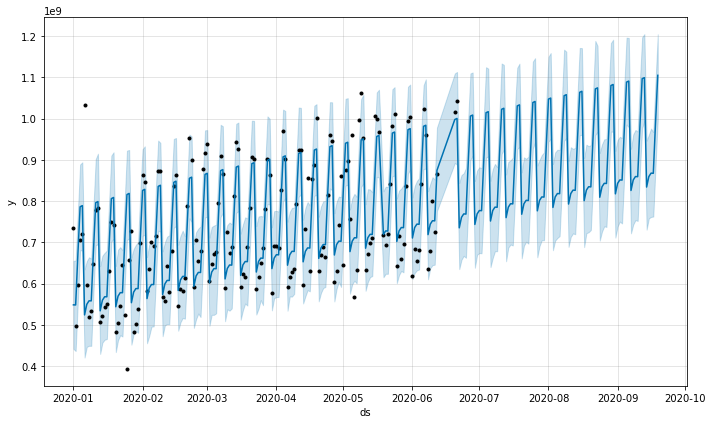

In [17]:
fig3 = m.plot(del_forecast)

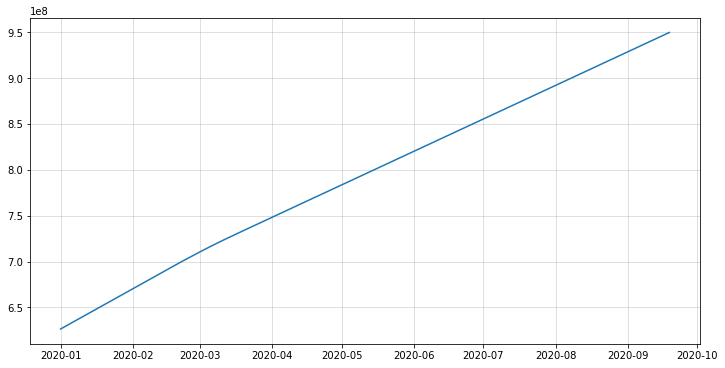

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(del_forecast['ds'].dt.to_pydatetime(), del_forecast['trend'])
plt.grid(alpha=0.5)

> 위를 통해 배달 산업의 성장이 꾸준히 이루어지고 있는 것을 알 수 있습니다. 이 결과로 저희는 구독경제 모델 중 배달산업을 이용한 __<span style="color:red">정기배송 서비스</span>__에 주목하기로 하였습니다.

## 2) **CARD데이터 분석하기**

> 앞서 말했던 구독경제와 엮을 수 있는 데이터를 찾기 위해 품목별 성장률을 시각화했습니다.

> 시각화 과정에서 갖고 잇는 6월까지의 데이터 이후도 예측모델을 통해 같이 시각화 했습니다.



### - **데이터 전처리**

>데이터의 전처리는 다음과 같은 기준으로 진행됐습니다.

> **첫째로**, 매출건수('selng_cascnt')의 결측치를 제거했습니다.

> **둘째로**, 업종('mrhst_induty_cl_nm')별 데이터를 쉽게 보기 위해 날짜('receipt_dttm'), 업종명, 매출건수 위주로 데이터를 편집했습니다.

> **셋째로**, 업종들 중에서 서비스로의 전환이 힘든 업종을 제외했습니다.

> **넷째로**, 성장률을 구할때 일단위 매출건수 평균이 너무 낮은 업종은 구독경제 전환시 안정성을 예측하기 어려워, 평균이 일정 기준을 넘지 못하면 데이터를 제외했습니다.

> **마지막으로**, 추려진 업종들 중에서, 저희가 정한 구독경제로의 전환이 어려운 업종들을 제외했습니다.


In [19]:
df1 = pd.read_csv("C:/Users/YH/Desktop/공모전/KT_data/card.csv", encoding='UTF-8')

#결측치 제거
stone = df1[df1['selng_cascnt']=='석재'].index
curtain = df1[df1['selng_cascnt']=='커텐'].index
media = df1[df1['selng_cascnt']=='영상물'].index
welfare = df1[df1['selng_cascnt']=='복지매장'].index
choock = df1[df1['selng_cascnt']=='축협직영매장'].index

df_1 = df1.drop(stone)
df_2 = df_1.drop(curtain)
df_3 = df_2.drop(media)
df_4 = df_3.drop(welfare)
df_fin = df_4.drop(choock)

df_fin['selng_cascnt_int'] = pd.to_numeric(df_fin['selng_cascnt']) # selng_cascnt 값을 int로 형 변환
selng = np.array(df_fin.selng_cascnt_int, dtype='int')

# receipt_dttm 데이터를 날짜 데이터로 변환하고 new_date 열에 추가
df_fin['new_date'] = df_fin['receipt_dttm'].apply(lambda x:pd.to_datetime(str(x), format='%Y%m%d')) 
df_fin.set_index(df_fin['new_date'], inplace=True)  # 인덱스 값을 new_date로 변경
df_fin = df_fin.drop(['adstrd_nm', 'adstrd_code', 'selng_cascnt','new_date'], 1) # 필요 없는 열 삭제

df_fin

,receipt_dttm,mrhst_induty_cl_code,mrhst_induty_cl_nm,salamt,selng_cascnt_int
new_date,,,,,
2020-01-04,20200104,7041,약국,5843230,463
2020-01-04,20200104,7022,치과의원,7835550,33
2020-01-04,20200104,7021,한의원,4589800,53
2020-01-04,20200104,7020,의원,9267240,339
2020-01-04,20200104,6110,자동차정비,4441000,19
...,...,...,...,...,...
2020-06-14,20200614,4004,대형할인점,1195640,136
2020-06-14,20200614,9010,인테 리어,13100,2
2020-06-14,20200614,6140,주 차 장,14500,2


In [20]:
#일평균 500넘는 업종 리스트 출력
data1 = df_fin.copy()

data2 = data1[['mrhst_induty_cl_nm','selng_cascnt_int']].reset_index(drop=False)
data3 = data2.groupby('mrhst_induty_cl_nm').sum().reset_index(drop=False)
data3['selng_cascnt_int'] = np.round(data3['selng_cascnt_int'] / 163, 0)

#일단위 매출건수 평균 기준 : 500
idx1 = data3[data3['selng_cascnt_int'] < 500].index
data3 = data3.drop(idx1).reset_index(drop=True)
over500_list = []

over500_list = data3['mrhst_induty_cl_nm'].unique()
over500_list

array(['CATV홈쇼핑', 'L P G', 'PG 상품권', '가전 제품', '가정용품수리', '고속 버스', '골프연습장',
       '공공 요금', '공공요금/대상', '구내매점(국가기관등)', '기계 공구', '기타 교육', '기타가구',
       '기타건강식', '기타건축자재', '기타대인서비스', '기타레져업', '기타사무용품', '기타숙박업',
       '기타용역서비스', '기타유통업', '기타음료식품', '기타의류', '기타잡화', '기타전기제품', '기타전문점',
       '기타회원제형태업소4', '내의판매점', '노래방', '농축수산품', '단란주점', '당구장', '대형할인점',
       '독서실', '동물병원', '레져업소(회원제형태)', '면 세 점', '문구용 품', '미 용 원', '미곡상',
       '미용 재료', '병원', '보습학원', '볼 링 장', '부동산중개/임대', '비 영 리', '비영리/비대상',
       '사무 기기', '사무서비스', '사무통신기기수리', '사우나', '사진관', '상품권', '생명 보험', '서양음식',
       '세 차 장', '세탁소', '소프트웨어', '손해 보험', '슈퍼 마켓', '스넥', '스크린골프',
       '스포츠레져용품', '스포츠의류', '신   발', '악세 사리', '안경', '애완 동물', '약국', '여 객 선',
       '연 쇄 점', '영화관', '예체능학원', '완 구 점', '외국어학원', '위성방송', '위탁급식업', '유아원',
       '유흥주점', '의료 용품', '의원', '이동통신요금', '인터넷Mall', '인터넷P/G', '인터넷종합Mall',
       '일반 서적', '일반백화점', '일반한식', '일식회집', '자동차부품', '자동차정비', '자사카드발행백화점',
       '장례서비스', '전문 서적', '정 수 기', '정 육 점', '정장', '제과점', '조세서비스',
       '조

**제외할 업종을 선정하는 기준은 다음과 같습니다.**

> 1. 일반인, 특히 직장인이 보편적으로 이용하지 않은 업종  
ex) 공무원연금매점, 중장비수리, 건축요업품 등  
2. 장소의 문제로 서비스 전환이 어려운 업종  
ex) 스키장, 1급호텔, 종합병원, 자동차정비, 유흥주점 등  
3. 이미 서비스로 이루어져 전환이 어려운 업종  
ex) P2P송금, 손해보험, 인터넷P/G 등  
4. 비영리가 목적인 업종  
ex) 비영리/비대상, 공공 요금 등
5. 업종명이 명확하지 않아, 선정이 어려운 업종  
ex) 기타음료식품, 기타전문점 등

In [21]:
#no_list : 제외하는 업종명 list

no_list = ['기타회원제형태업소4', '기타건강식','여 객 선','기타의류','치과의원', '동물병원', '연 쇄 점', '한의원', '애완 동물', 
           '스크린골프','의원', '기타대인서비스', '기타가구', '기타전기제품','병원', '기타음료식품','기타전문점',
           '1급 호텔', '2급 호텔', 'L P G', '가정용품수리', '건축요업품', '고속 버스', '공공 요금', '골프경기장', '골프연습장', 
           '공공요금/대상','공무원연금매점', '과학기자재', '관광여행','구내매점(국가기관등)','국산 신차', '기계 공구', 
           '기타건축자재', '기타레져업', '기타비영리유통','기타숙박업', '기타용역서비스','기타유통업','기타의료기관및기타의료기기',
           '노래방','단란주점','당구장','독서실','레져업소(회원제형태)','렌 트 카', '면 세 점', '미 용 원', '법률회계서비스(개인)',
           '법률회계서비스(법인)','볼 링 장','부동산중개/임대','비 영 리','비영리/비대상','사우나','생명 보험','세 차 장',
           '손해 보험','수 족 관','수입자동차','스 키 장','위성방송','위탁급식업','유흥주점','의료 용품','이 용 원','이동통신요금',
           '이륜차판매','인터넷P/G','자동차부품','자동차시트/타이어','자동차정비','장례서비스','제약회사','조세서비스',
           '조세서비스(특약)','종합용역','주 유 소','주 차 장','주점','철   도','택   시','특급 호텔',
           '항 공 사','헬스 크럽','혼례서비스','화물 운송','침구수예점','영화관','상품권','자사카드발행백화점','서양음식','종합병원']

**최종적으로 선정한 업종명 list입니다**

In [22]:
over500_list = set(over500_list)
no_list = set(no_list)

over500_list = over500_list - no_list
fin_list = list(over500_list.copy())

#fin_list : 분석해볼 업종명들 list(58개)

**card데이터를 업종별로 이상치 제거를 해주었습니다.**

In [23]:
d1 = pd.DataFrame(columns=df_fin.columns)

for j in range(len(fin_list)):
    d2 = df_fin[df_fin['mrhst_induty_cl_nm'] == fin_list[j]]
    d2 = d2.reset_index()
    d1 = pd.concat([d1, remove_outlier(d2, 'selng_cascnt_int')],axis=0,ignore_index = True)
d3 = d1['mrhst_induty_cl_nm'].unique()
d1.set_index(d1['new_date'], inplace=True)

In [24]:
df_last = d1.copy()
# 업종 이름 별 새 데이터 프레임 작성
categories = df_last.groupby(df_last.mrhst_induty_cl_nm)
category = pd.DataFrame(categories) 

# 업종 이름
predicting_cate = fin_list
# 업종 이름별 데이터 셋
predicting_selng = np.array(category[1])

### - **card 데이터 분석**


**상품 판매량 추이(매출건수 기준)을 예측하고 성장률을 산출하는 함수입니다.**

In [25]:
# 매개변수 'pre_cate'에 '업종 이름'의 배열을 넣어 상품 판매량 추이를 예측
def seperate(pre_cate):
    percentage = np.array(pre_cate)
    # 진행률을 알기 위해 10% 단위로 표기
    for i in range(len(pre_cate)):  
        if i%6 == 0:
            print(i/6*10, '%')
        
        predicting_cate = pre_cate[i]
        # 해당 업종의 날짜 데이터, 판매량 데이터 만 추출 
        data_amount = categories.get_group(predicting_cate)[['new_date', 'selng_cascnt_int']].reset_index(drop=True)
        data_amount = data_amount.rename(columns={'new_date' : 'ds', 'selng_cascnt_int' : 'y'})
        
        # 데이터 수가 100개 이하인 항목 예측에서 제외
        if data_amount.shape[0] <= 100 :
            continue
        
        # prophet 객체 생성 & Fit
        m = Prophet(changepoint_range=0.9) 
        m.fit(data_amount)
        
        # 예측 날짜 구간 생성(+90일)
        future = m.make_future_dataframe(periods=90)
        # 신뢰 구간을 포함한 예측 실행
        forecast = m.predict(future)
        
        # temp = 예측된 날짜별 추세값
        temp = forecast.groupby('ds')['trend'].mean()
        fin = np.array(temp)
        
        #  fin[-1] : 예측한 90일 후의 판매량 값  //  fin[-91] : 실제로 관측된 가장 마지막 판매량 값
        
        percent = (((fin[-1]) - (fin[-91])) / abs(fin[-91])) * 100
        percentage[i] = round(percent, 2)
        
    # 업종 이름, 판매량 추이(상승률 %로 나타냄)를 하나의 배열로 병합
    cate_percentage = np.c_[pre_cate, percentage]
    return cate_percentage

In [26]:
# 모든 업종별 판매량 추이를 예측
total_percentage = seperate(predicting_cate)

0.0 %
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %


In [27]:
list_total_percentage = total_percentage.tolist()
# 데이터량이 100개가 안되는 카테고리 -> 삭제
less_100 = ['교육테이프', '비씨카드정산용(할인)', '외국인전용가맹점',
                '조산원', '중고자동차위탁판매', '총포류판매',
                '통신기기무이자할부', '통신판매(생활서비스)']

count = 0
for i in range(len(total_percentage)):
    for j in less_100:
        if total_percentage[i, 1] == j:
            del list_total_percentage[i-count]
            count += 1
            
cate_percentage = np.array(list_total_percentage) 

# 업종명
fin_catt = cate_percentage[:, 0] 
# 판매량 추이(%)
fin_perc = cate_percentage[:, 1]  

#print(fin_perc)
fin_perc = fin_perc.astype(float)  # float으로 형 변환

In [28]:
cate_percentage[:, 0] = fin_catt
cate_percentage[:, 1] = fin_perc

# 판매량 추이(%) 기준 내림차순 정렬
sort_idx = sorted(range(len(cate_percentage)), key=lambda i: fin_perc[i], reverse=True)

# 판매량 추이(%) 상위 10개의 항목 추출
top_10_idx = sorted(range(len(cate_percentage)), key=lambda i: fin_perc[i], reverse=True)[:10]
top10_cate_perc = cate_percentage[top_10_idx]
print(top10_cate_perc)

top_10_nm = cate_percentage[top_10_idx, 0]

[['사무서비스' '118.44']
 ['내의판매점' '67.0']
 ['사무 기기' '48.72']
 ['화 장 품' '38.47']
 ['가전 제품' '34.14']
 ['편 의 점' '32.46']
 ['출판인쇄물' '28.66']
 ['대형할인점' '21.74']
 ['일반백화점' '20.05']
 ['기타잡화' '19.27']]


### - **데이터 시각화**

In [35]:
# 판매량 추이(%) 상위 10개 항목 그래프로 시각화

def show_top10(pre_cate):
    percentage = np.array(pre_cate)
    for i in range(len(pre_cate)):
        predicting_cate = pre_cate[i]
        data_amount = categories.get_group(predicting_cate)[['new_date', 'selng_cascnt_int']].reset_index(drop=True)
        data_amount = data_amount.rename(columns={'new_date' : 'ds', 'selng_cascnt_int' : 'y'})
        m = Prophet(changepoint_range=0.9, changepoint_prior_scale= 0.5) 
        m.fit(data_amount)
        
        future = m.make_future_dataframe(periods=90)
        forecast = m.predict(future)
        
        # 원 시계열 데이터와 예측 데이터를 plot
        fig1 = m.plot(forecast, uncertainty=False, figsize=(12, 6))
        
        # 90일의 예측값을 plot
        forecast.iloc[-90:, :].yhat.plot
        
        # 선형회귀 예측값을 plot
        plt.title("no.%d %s" %((i+1), pre_cate[i]), fontsize=25)
        plt.figure(figsize=(14, 6))
        plt.plot(forecast['ds'].dt.to_pydatetime(), forecast['trend'])
        plt.ylabel('Predicted_Trend')
        plt.grid(alpha=0.5)
        
        
        temp = forecast.groupby('ds')['trend'].mean()
        fin = np.array(temp)
        percent = (((fin[-1]) - (fin[-91])) / abs(fin[-91])) * 100
        percentage[i] = round(percent, 2)
        print("no.%d " %(i+1), "||", pre_cate[i], "||", top10_cate_perc[i, 1], "%")

no.1  || 사무서비스 || 118.44 %
no.2  || 내의판매점 || 67.0 %
no.3  || 사무 기기 || 48.72 %
no.4  || 화 장 품 || 38.47 %
no.5  || 가전 제품 || 34.14 %
no.6  || 편 의 점 || 32.46 %
no.7  || 출판인쇄물 || 28.66 %
no.8  || 대형할인점 || 21.74 %
no.9  || 일반백화점 || 20.05 %
no.10  || 기타잡화 || 19.27 %


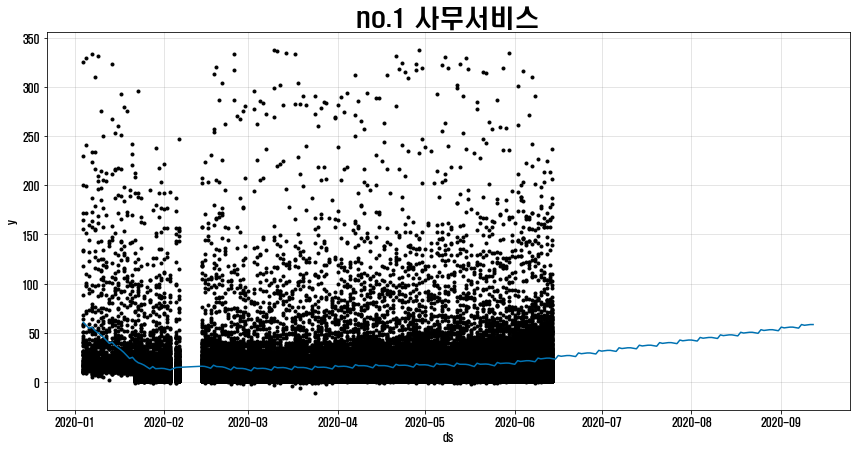

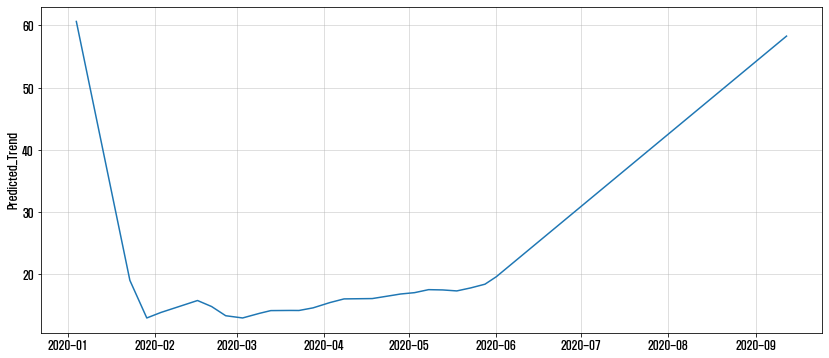

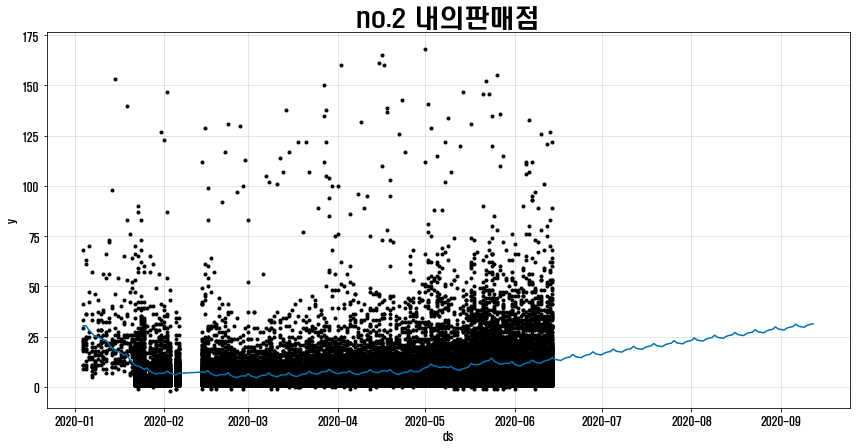

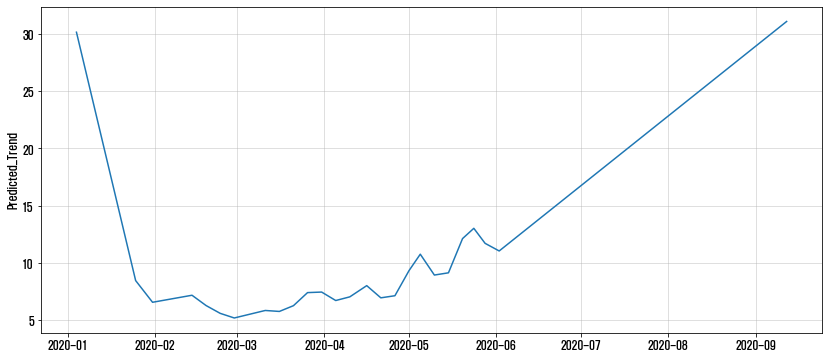

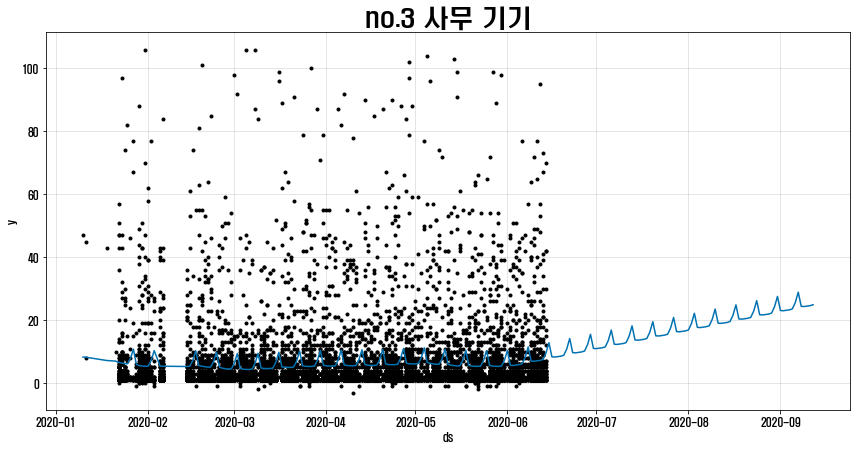

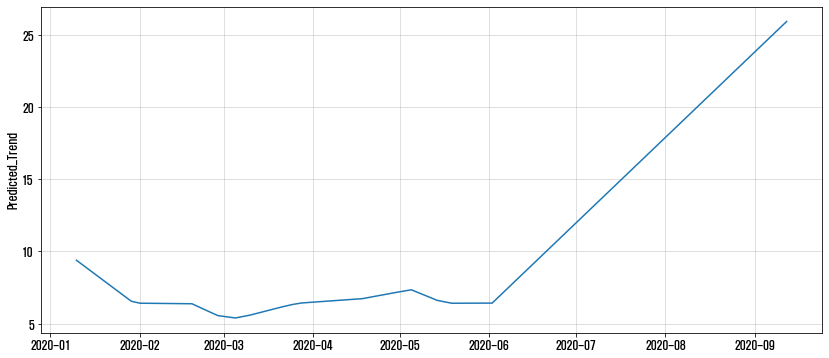

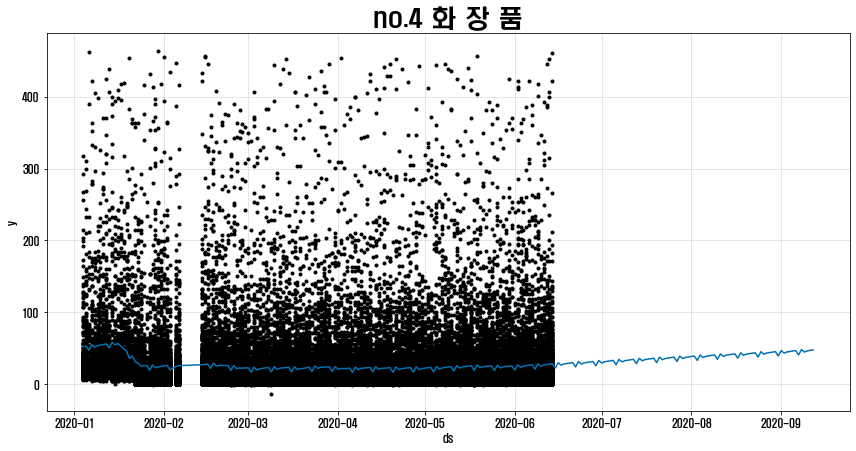

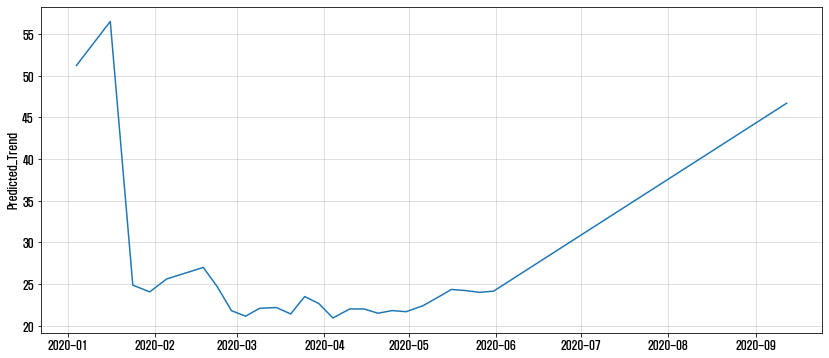

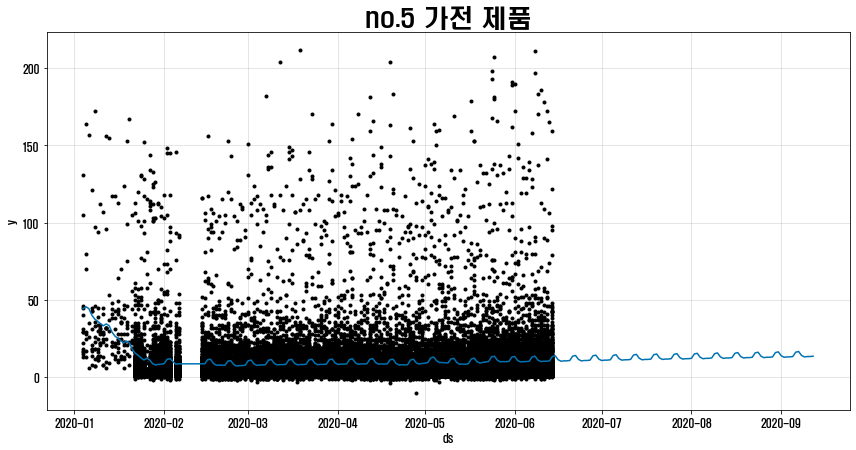

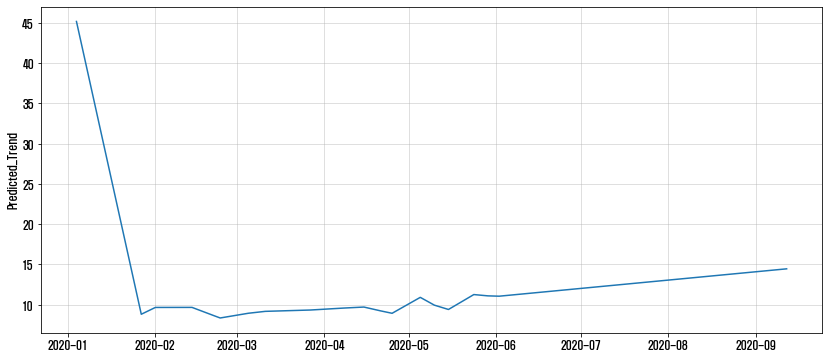

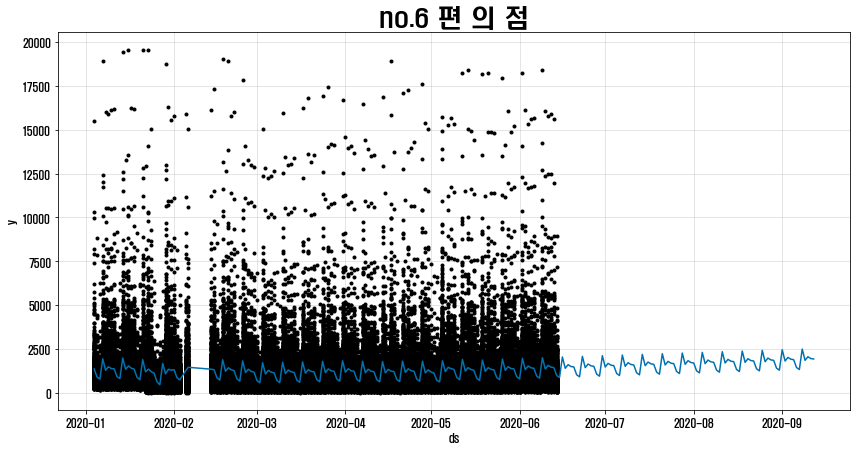

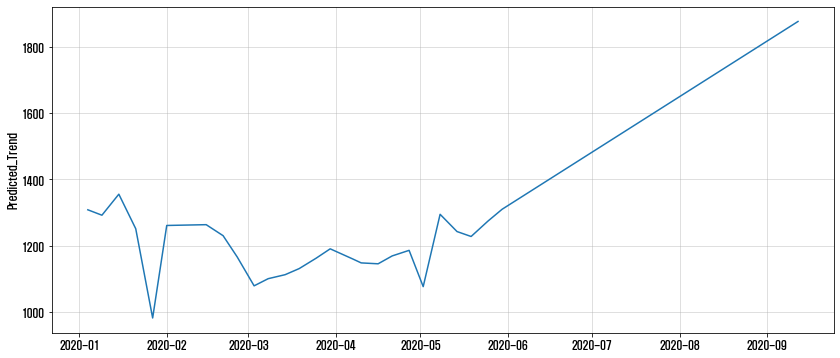

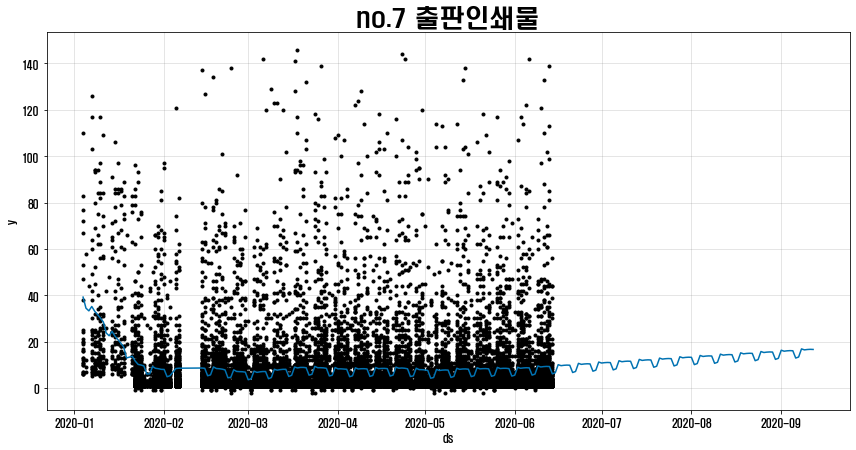

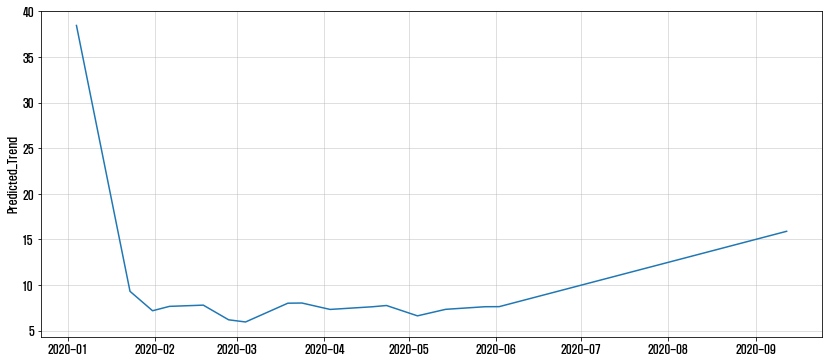

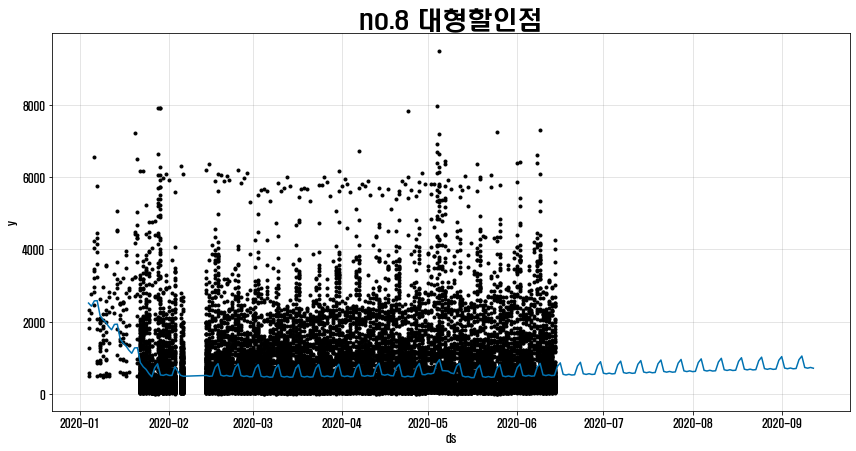

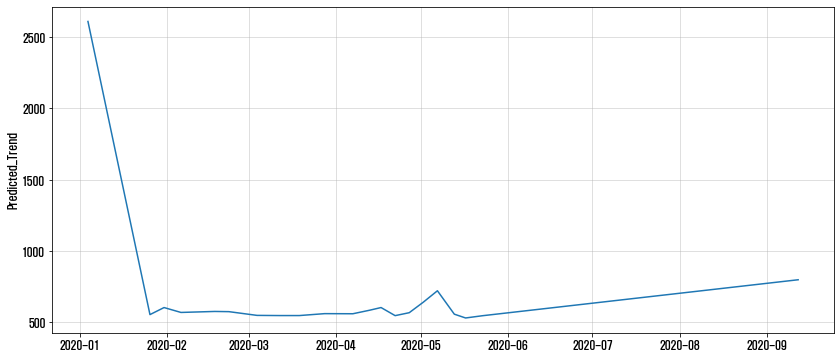

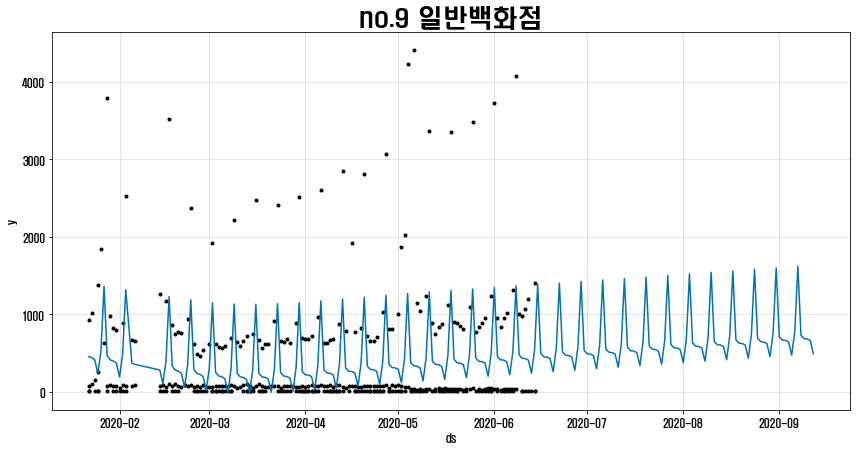

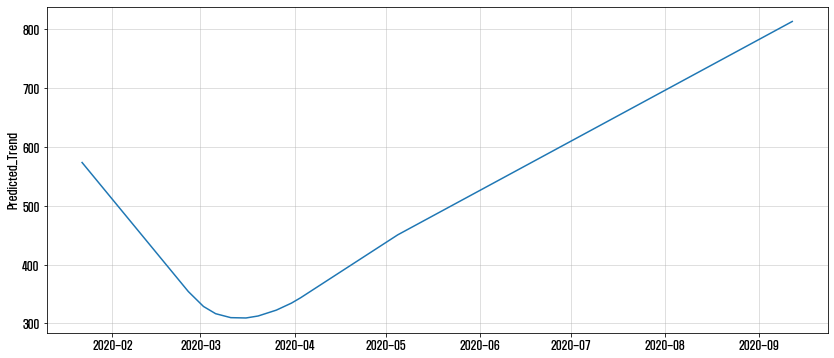

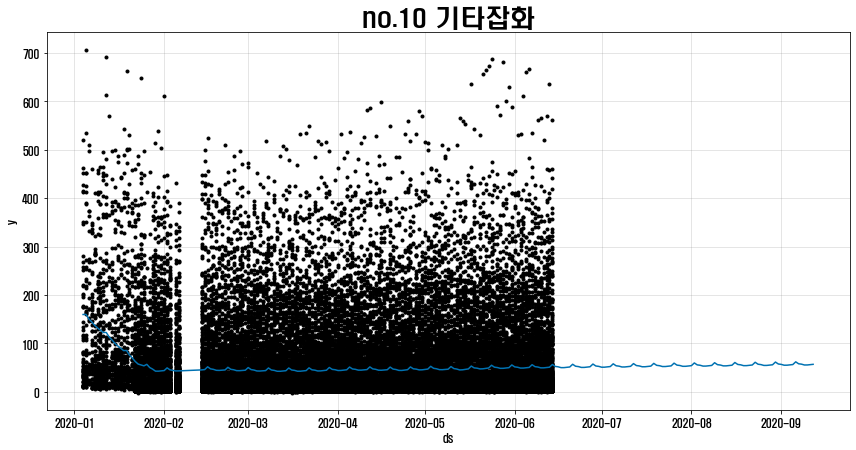

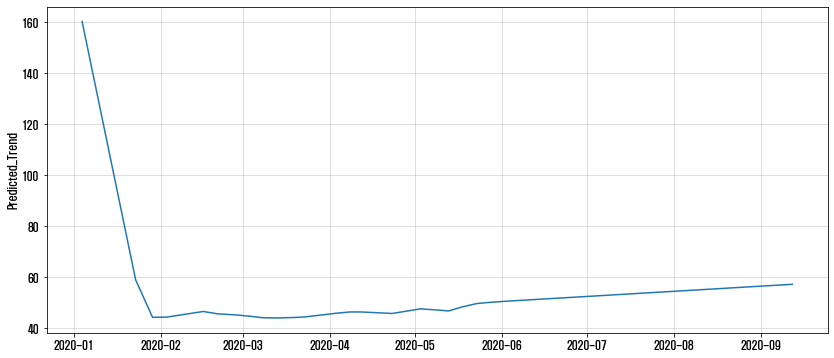

In [36]:
show_top10(top_10_nm)

# <div id="indexfour">04.결론 및 활용 방안</div>











## 1) __pss의 개념__

① pss란?
> 고객의 필요를 만족시키면서 기존의 비즈니스 모델에 비해 환경적 부담을 줄임으로써 경쟁력 있게 설계된 __Product (P)와 Service (S), 그리고 관련된 네트워크 및 인프라를 포함하는 System(S)__.

② pss의 형태
> * __제품 중심 PSS (Product Oriented PSS)__: 제품을 판매한 후 부가적으로 서비스 기능을 제공하는 형태  

> * __사용 중심 PSS (Use Oriented PSS)__: 제품을 판매하지 않고 생산자가 소유권을 가지며 다수의 소비자가 그 기능을 공유하는 형태  

> * __결과 중심 PSS (Result Oriented PSS)__: 고객과 공급자가 상호간 성과에 대해 이익을 배분하는 형태  

## 2) PSS산업의 성장 동향과 사례



![](https://img1.daumcdn.net/thumb/R720x0.q80/?scode=mtistory2&fname=http%3A%2F%2Fcfile21.uf.tistory.com%2Fimage%2F995A1A335C7CCE05214624)


출처 : https://khanarchive.khan.kr/m/6549

추가자료 : http://www.upinews.kr/newsView/upi202005130119

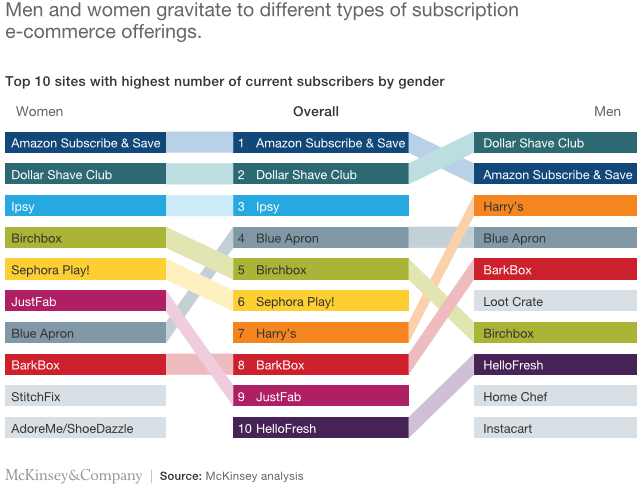

In [31]:
Image('C:/Users/YH/Desktop/공모전/mackin.png')

>글로벌 PSS산업 규모가 2020년 기준 5300억 달러까지 성장할 것으로 기대된다

>우리가 분석한 상위 10위 내에 위치한 내의 판매점, 화장품, 기타잡화 등이 미국 시장 기준 Ipsy(화장품), Sephora Play(화장품), Birchbox(화장품), AdoreMe(내의), Blue Apron(식료품) 등이 상위권에 포진해 있는 것을 확인할 수 있다. 

>구독경제 시장 성장 곡선을 그리고 있는 국내에서도 top10 카테고리의 정기구독 서비스 제공이 유망할 것으로 기대된다.

## 3) pss 조합하기
#### - (내의판매점, 화장품, 기타잡화) + 정기 배송 서비스
#### - (편의점, 대형할인점, 일반백화점) + 정기 배송 서비스
#### - (가전제품) + 정기 배송 서비스
#### - (사무기기, 출판인쇄물) + 정기 배송 서비스

>PSS 중 분석 결과로 나온 상위 10위권 내의 업종인 **내의판매점, 화장품, 기타잡화, 편의점, 대형할인점, 일반백화점, 가전제품, 사무기기, 출판인쇄물**과 **정기 배송 서비스** 즉, Product 와 구독경제 모델 중 현재 포스트 코로나 시대의 이용이 적합한 정기배송 서비스 모델인 Service를 결합하여 PSS( Product Service System)을 조합해보았습니다. 특히 사무기기 및 출판 인쇄물 같은 경우 재택근무를 하는 직장인들의 업무 효율성 증진 효과를 기대할 수 있습니다.  



## 4) 결론
>위의 사례에서 볼 수 있듯이 구독 경제가 활발하게 이뤄지고 있는 해외의 사례와는 달리 우리나라에서는 현재 PSS 산업는 시작 단계라고 할 수 있습니다. 하지만 포스트 코로나 시대가 출현하면서 가정에서의 시간이 길어진 현대 사회인들을 위한 PSS 산업은 이제 더 이상 시작 단계로만 머물지 않을 것으로 예상됩니다. 특히, 코로나 시대의 도래로 자택 근무가 늘어난 직장인들을 위한 사무기기 및 출판 인쇄물의 정기 배송 서비스는 업무의 효율을 끌어올리는 데에 도움을 줄 것입니다. 이는 자택 근무의 영향으로 업무의 비효율성을 걱정하는 회사 측과 집에서도 업무의 효율성을 증진시키려는 직장인들의 니즈를 충분히 만족시켜줄 수 있는 새로운 사업으로 떠오를 수 있을 것이라고 생각됩니다.